In [10]:
import os
import math
from math import atan
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# Create theoretical and measured waypoint data

# final experimental sequece: 
    # forward 2 meters at speed 150
    # turn -1.5 rotations at speed 150
    # forward 5 meters at speed 150
    # turn -2.5 rotations at speed 150
    # forward 150 at speed 150
    # turn -8 rotations at speed 100
    # forward 4 meters at speed 50
theoretical_waypoints_true = (
    # in units of [cm], [cm], [rotations]
    (0, 0, 0),
    (200, 0, 0),
    (200, 0, -1.5),
    (-300, 0, -1.5),
    (-300, 0, -4),
    (-150, 0, -4),
    (-150, 0, -12),
    (250, 0, -12)
)

theoretical_waypoints = (
    # in units of [cm], [cm], [rotations]
    (0, 0, 0),
    (200, 5, 0),
    (-300, 10, -1.5),
    (-150, 15, -4),
    (250, 20, -12)
)

measured_waypoints_inches = (
    # in units of [in], [in]
    (0, 0, 0),
    (32.4, -2.4),
    #(32.4, -2.4),
    (-0.9, -75.4),
    #(-0.9, -75.4),
    (20.3, -70.3),
    #(20.3, -70.3),
    (-67.5, 37.5)
)

measured_waypoints = tuple(
    # in units of [cm], [cm]
    (
        point[0] * 2.54,  # inches to cm
        point[1] * 2.54,  # inches to cm
    ) for point in measured_waypoints_inches
)

# data to use for final plot: 
    # theoretical_waypoints
    # measured_waypoints

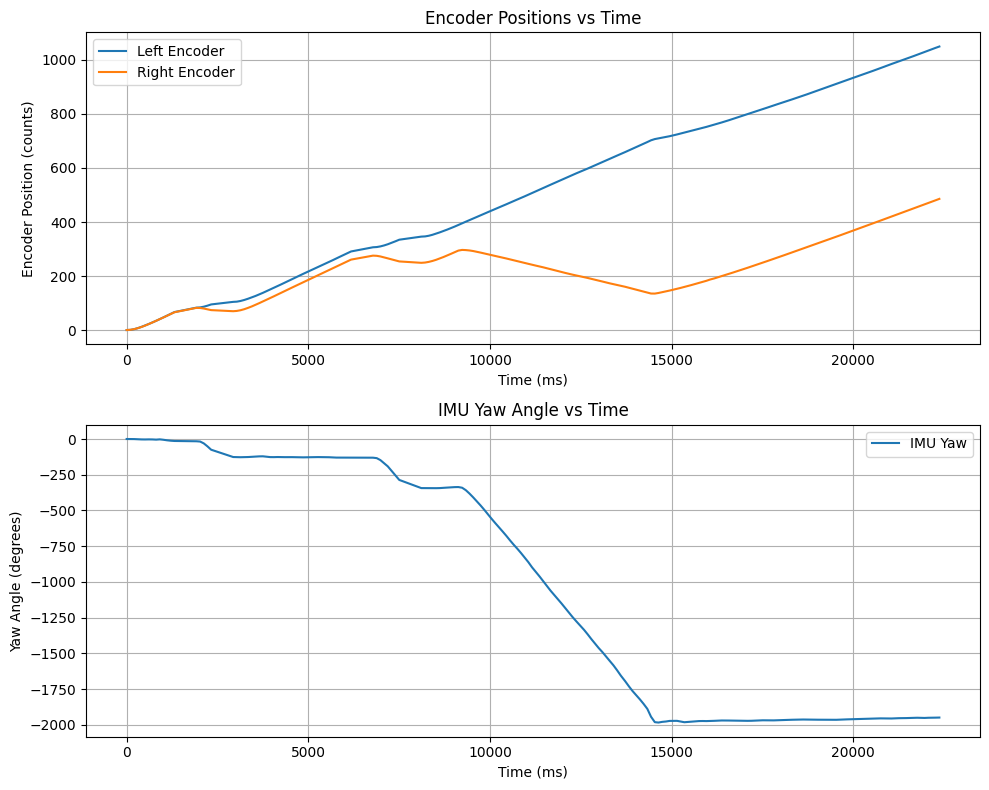

In [24]:
# Plot RAW data from l4data_final.csv

data_path = os.path.join(os.getcwd(), 'l4data_final.csv')

with open(data_path, 'r') as f:
    data = f.readlines()

# Parse the CSV data into lists
times = []
left_positions = []
right_positions = [] 
yaws = []

for line in data:
    t, l, r, y = line.strip().split(',')
    times.append(float(t))
    left_positions.append(float(l))
    right_positions.append(float(r))
    yaws.append(float(y))

# Create subplots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# Plot encoder positions
ax1.plot(times, left_positions, label='Left Encoder')
ax1.plot(times, right_positions, label='Right Encoder')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Encoder Position (counts)')
ax1.legend()
ax1.grid(True)
ax1.set_title('Encoder Positions vs Time')

# Plot IMU yaw angle
ax2.plot(times, yaws, label='IMU Yaw')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Yaw Angle (degrees)')
ax2.legend()
ax2.grid(True)
ax2.set_title('IMU Yaw Angle vs Time')

plt.tight_layout()
plt.show()



In [61]:
# Perform naive FK integration of the wheel data

data_path = os.path.join(os.getcwd(), 'l4data_final.csv')

with open(data_path, 'r') as f:
    data = f.readlines()

# Parse the CSV data into lists
times = []
left_positions = []
right_positions = [] 
yaws = []

for line in data:
    t, l, r, y = line.strip().split(',')
    times.append(float(t))
    left_positions.append(float(l))
    right_positions.append(float(r))
    yaws.append(float(y))

l = 6*2.54 # wheelbase diameter in [cm]
integrated_positions = [(0, 0, 0)] # in [cm, cm, rad]

# Loop through all data points
for i in range(1, len(left_positions)):
    # Get changes in left and right wheel positions
    delta_left = left_positions[i] - left_positions[i-1]  # cm
    delta_right = right_positions[i] - right_positions[i-1]  # cm

    # Calculate change in orientation (theta)
    delta_theta = (delta_right - delta_left) / l  # rad

    # Calculate distance traveled by center point
    delta_distance = (delta_right + delta_left) / 2  # cm

    # Calculate changes in x and y position
    # Use average theta during the step
    theta_avg = integrated_positions[-1][2] + delta_theta/2
    delta_x = delta_distance * math.cos(theta_avg)  # cm
    delta_y = delta_distance * math.sin(theta_avg)  # cm

    # Calculate new x, y, theta
    new_x = integrated_positions[-1][0] + delta_x
    new_y = integrated_positions[-1][1] + delta_y  
    new_theta = integrated_positions[-1][2] + delta_theta

    # Append the new position
    integrated_positions.append((new_x, new_y, new_theta))

# Print final position
print(f"Final position:")
print(f"x: {integrated_positions[-1][0]:.2f} cm")
print(f"y: {integrated_positions[-1][1]:.2f} cm")
print(f"θ: {math.degrees(integrated_positions[-1][2]):.2f} degrees")

Final position:
x: 348.18 cm
y: -21.09 cm
θ: -2120.53 degrees


201
201
201
201
201
201
20
i:  0
i:  20
i:  40
i:  60
i:  80
i:  100
i:  120
i:  140
i:  160
i:  180
i:  200


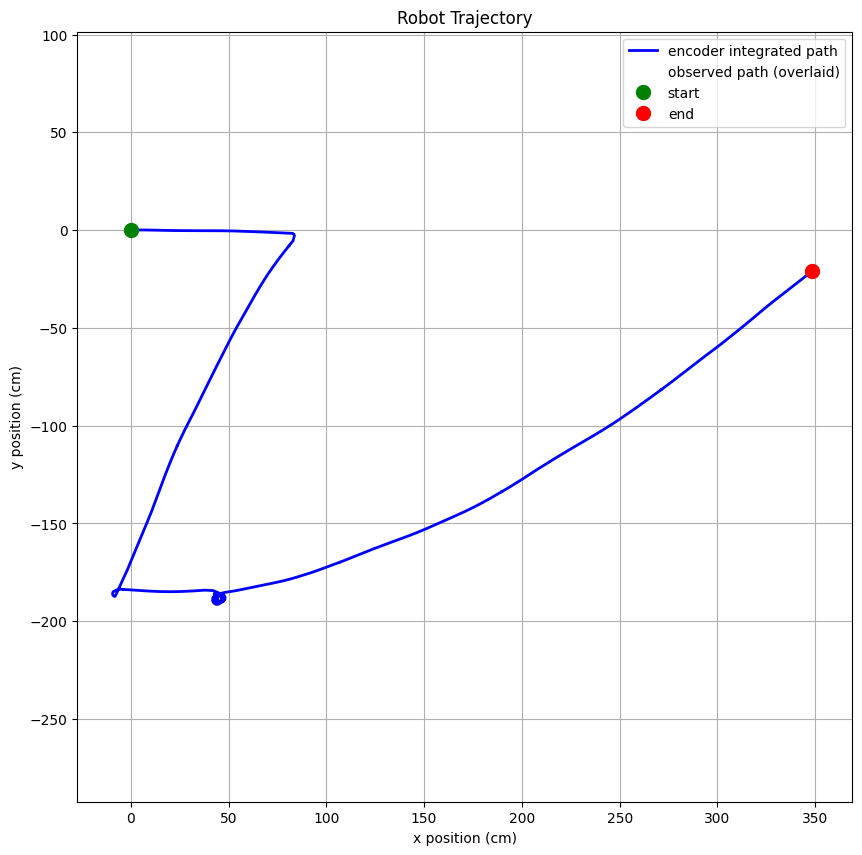

In [11]:
# Plot FK results

# Convert integrated_positions to numpy arrays for easier plotting
positions = np.array(integrated_positions)
x = positions[:, 0]
y = positions[:, 1]
theta = positions[:, 2]

print(len(positions))
print(len(x))
print(len(y))
print(len(theta))

# Create the plot
plt.figure(figsize=(10, 10))

# plot encoder integrated path
plt.plot(x, y, 'b-', label='encoder integrated path', linewidth=2)

# add 'observed path' to plot key
plt.plot((0,), (0,), 'w.', label='observed path (overlaid)', linewidth=2)

# Add orientation arrows at regular intervals
print(len(x))
print(len(theta))
arrow_interval = len(x) // 10  # Show 10 arrows along the path
print(arrow_interval)
for i in range(0, len(x), arrow_interval):
    print('i: ', i)
    # Calculate arrow direction
    dx = 2 * np.cos(theta[i])  # 2cm length arrows
    dy = 2 * np.sin(theta[i])
    plt.arrow(x[i], y[i], dx, dy, 
             head_width=0.5*2, head_length=0.8*2, fc='b', ec='b')

# Add theoretical path here

# Add start and end markers
plt.plot(x[0], y[0], 'go', label='start', markersize=10)
plt.plot(x[-1], y[-1], 'ro', label='end', markersize=10)

# Customize the plot
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio
plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')
plt.title('Robot Trajectory')
plt.legend()

# Show the plot
plt.show()

In [118]:
# Perform Kalman filtered integration of the wheel data
# with PQR such that only the IMU yaw is trusted

data_path = os.path.join(os.getcwd(), 'l4data_final.csv')

with open(data_path, 'r') as f:
    data = f.readlines()

# Parse the CSV data into lists
times = []
left_positions = []
right_positions = [] 
yaws = []

for line in data:
    t, l, r, y = line.strip().split(',')
    times.append(float(t))
    left_positions.append(float(l))
    right_positions.append(float(r))
    yaws.append(math.radians(float(y)))

l = 6*2.54 # wheelbase diameter in [cm]
imu_integrated_positions = [np.array([0.0, 0.0, 0.0])] # in [cm, cm, rad]

P = np.array([[0.0, 0.0, 0.0],  # The x and y position entries are 0 because
              [0.0, 0.0, 0.0],  # we do not have any better sensor data for x and y
              [0.0, 0.0, 1000]]) # so we must fully trust forward kinematics.
Q = np.array([[0.0, 0.0, 0.0], 
              [0.0, 0.0, 0.0], 
              [0.0, 0.0, 10]])
R = np.array([[1.0, 0.0, 0.0], 
              [0.0, 1.0, 0.0], 
              [0.0, 0.0, 10.0]])

# Loop through all data points
for i in range(1, len(left_positions)):

    # Kalman filter LINE 1, carried over from lab 3

    # Get changes in left and right wheel positions
    delta_left = left_positions[i] - left_positions[i-1]  # cm
    delta_right = right_positions[i] - right_positions[i-1]  # cm

    # Calculate change in orientation (theta)
    delta_theta = (delta_right - delta_left) / l  # rad

    # Calculate distance traveled by center point
    delta_distance = (delta_right + delta_left) / 2  # cm

    # Calculate changes in x and y position
    # Use average theta during the step
    theta_avg = imu_integrated_positions[-1][2] + delta_theta/2
    delta_x = delta_distance * math.cos(theta_avg)  # cm
    delta_y = delta_distance * math.sin(theta_avg)  # cm

    # Calculate new x, y, theta
    new_x = imu_integrated_positions[-1][0] + delta_x
    new_y = imu_integrated_positions[-1][1] + delta_y  
    new_theta = imu_integrated_positions[-1][2] + delta_theta

    # vectorize the new position
    x_vector = np.array([new_x, new_y, new_theta])

    # Kalman filter LINE 2
    P = P + Q

    # Kalman filter LINE 3
    K = P @ np.linalg.inv(P + R)

    # Kalman filter LINE 4
    z_vector = np.array([1.0, 1.0, yaws[i]]) # We have no sensor information for x and y
    x_vector = x_vector + K @ (z_vector - x_vector)

    # Kalman filter LINE 5
    P = (np.eye(3) - K) @ P

    # Append the new position
    imu_integrated_positions.append(x_vector)

# Print final position
print(f"Final position:")
print(f"x: {imu_integrated_positions[-1][0]:.2f} cm")
print(f"y: {imu_integrated_positions[-1][1]:.2f} cm")
print(f"θ: {math.degrees(imu_integrated_positions[-1][2]):.2f} degrees")

Final position:
x: -319.87 cm
y: -257.10 cm
θ: -1949.24 degrees


In [147]:
# Perform Kalman filtered integration of the wheel data with intermediate PQR

data_path = os.path.join(os.getcwd(), 'l4data_final.csv')

with open(data_path, 'r') as f:
    data = f.readlines()

# Parse the CSV data into lists
times = []
left_positions = []
right_positions = [] 
yaws = []

for line in data:
    t, l, r, y = line.strip().split(',')
    times.append(float(t))
    left_positions.append(float(l))
    right_positions.append(float(r))
    yaws.append(math.radians(float(y)))

l = 6*2.54 # wheelbase diameter in [cm]
kalman_integrated_positions = [np.array([0.0, 0.0, 0.0])] # in [cm, cm, rad]

P = np.array([[0.0, 0.0, 0.0],  # The x and y position entries are 0 because
              [0.0, 0.0, 0.0],  # we do not have any better sensor data for x and y
              [0.0, 0.0, 0.03]]) # so we must fully trust forward kinematics.
Q = np.array([[0.0, 0.0, 0.0], 
              [0.0, 0.0, 0.0], 
              [0.0, 0.0, 0.0001]])
R = np.array([[1.0, 0.0, 0.0], 
              [0.0, 1.0, 0.0], 
              [0.0, 0.0, 1.0]]) # @FHERE

# Loop through all data points
for i in range(1, len(left_positions)):

    # Kalman filter LINE 1, carried over from lab 3

    # Get changes in left and right wheel positions
    delta_left = left_positions[i] - left_positions[i-1]  # cm
    delta_right = right_positions[i] - right_positions[i-1]  # cm

    # Calculate change in orientation (theta)
    delta_theta = (delta_right - delta_left) / l  # rad

    # Calculate distance traveled by center point
    delta_distance = (delta_right + delta_left) / 2  # cm

    # Calculate changes in x and y position
    # Use average theta during the step
    theta_avg = kalman_integrated_positions[-1][2] + delta_theta/2
    delta_x = delta_distance * math.cos(theta_avg)  # cm
    delta_y = delta_distance * math.sin(theta_avg)  # cm

    # Calculate new x, y, theta
    new_x = kalman_integrated_positions[-1][0] + delta_x
    new_y = kalman_integrated_positions[-1][1] + delta_y  
    new_theta = kalman_integrated_positions[-1][2] + delta_theta

    # vectorize the new position
    x_vector = np.array([new_x, new_y, new_theta])

    # Kalman filter LINE 2
    P = P + Q

    # Kalman filter LINE 3
    K = P @ np.linalg.inv(P + R)

    # Kalman filter LINE 4
    z_vector = np.array([1.0, 1.0, yaws[i]]) # We have no sensor information for x and y
    x_vector = x_vector + K @ (z_vector - x_vector)

    # Kalman filter LINE 5
    P = (np.eye(3) - K) @ P

    # Append the new position
    kalman_integrated_positions.append(x_vector)

# Print final position
print(f"Final position:")
print(f"x: {kalman_integrated_positions[-1][0]:.2f} cm")
print(f"y: {kalman_integrated_positions[-1][1]:.2f} cm")
print(f"θ: {math.degrees(kalman_integrated_positions[-1][2]):.2f} degrees")

Final position:
x: -143.10 cm
y: 76.75 cm
θ: -2001.45 degrees


201
201
201
201
201
201
20
i:  0
i:  20
i:  40
i:  60
i:  80
i:  100
i:  120
i:  140
i:  160
i:  180
i:  200


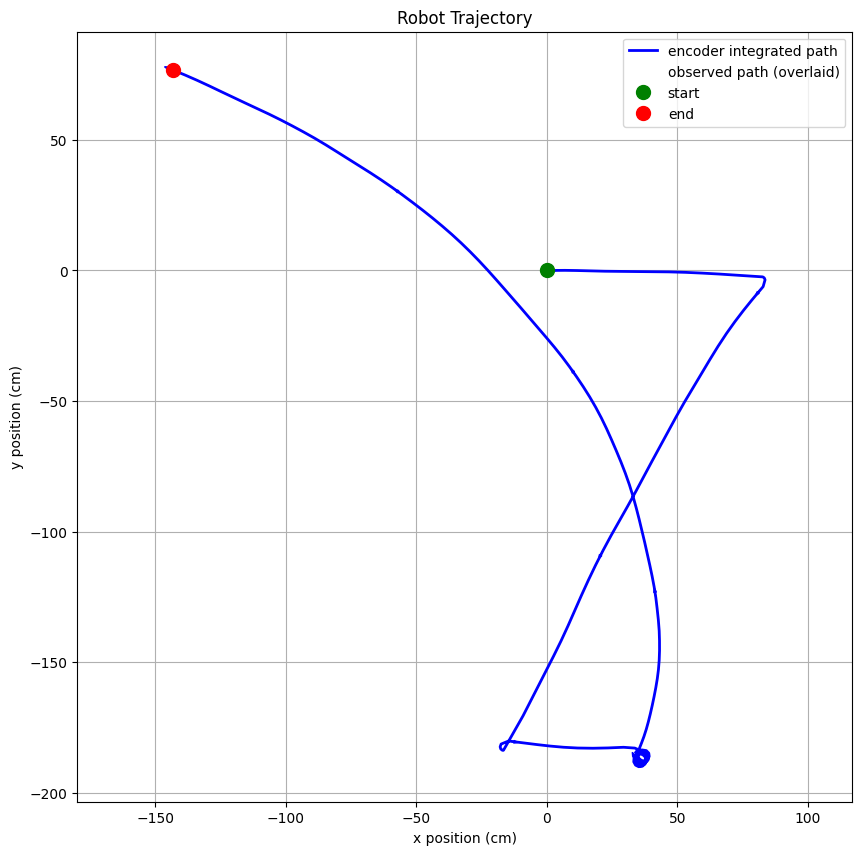

In [148]:
# Plot Kalman results

# Convert integrated_positions to numpy arrays for easier plotting
kalman_integrated_positions = np.array(kalman_integrated_positions)
x = kalman_integrated_positions[:, 0]
y = kalman_integrated_positions[:, 1]
theta = kalman_integrated_positions[:, 2]

print(len(kalman_integrated_positions))
print(len(x))
print(len(y))
print(len(theta))

# Create the plot
plt.figure(figsize=(10, 10))

# plot encoder integrated path
plt.plot(x, y, 'b-', label='encoder integrated path', linewidth=2)

# add 'observed path' to plot key
plt.plot((0,), (0,), 'w.', label='observed path (overlaid)', linewidth=2)

# Add orientation arrows at regular intervals
print(len(x))
print(len(theta))
arrow_interval = len(x) // 10  # Show 10 arrows along the path
print(arrow_interval)
for i in range(0, len(x), arrow_interval):
    print('i: ', i)
    # Calculate arrow direction
    dx = 2 * np.cos(theta[i])  # 2cm length arrows
    dy = 2 * np.sin(theta[i])
    plt.arrow(x[i], y[i], dx, dy, 
             head_width=0.5*2, head_length=0.8*2, fc='b', ec='b')

# Add theoretical path here

# Add start and end markers
plt.plot(x[0], y[0], 'go', label='start', markersize=10)
plt.plot(x[-1], y[-1], 'ro', label='end', markersize=10)

# Customize the plot
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio
plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')
plt.title('Robot Trajectory')
plt.legend()

# Show the plot
plt.show()

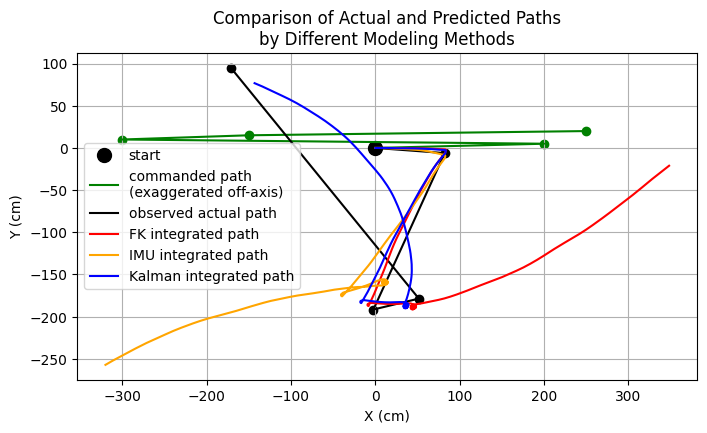

In [152]:
# final plot of theoretical vs measured waypoints, FK, and Kalman integration

# data to use
# theoretical_waypoints
# measured_waypoints
# integrated_positions
# kalman_integrated_positions


fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')

# start marker
ax.plot((0,), (0,), 'ko', label='start', markersize=10)

# theoretical_waypoints
theoretical_x = [point[0] for point in theoretical_waypoints]
theoretical_y = [point[1] for point in theoretical_waypoints]
ax.scatter(theoretical_x, theoretical_y, color='green')
ax.plot(theoretical_x, theoretical_y, color='green', label='commanded path\n(exaggerated off-axis)')

# measured_waypoints
measured_x = [point[0] for point in measured_waypoints]
measured_y = [point[1] for point in measured_waypoints]
ax.scatter(measured_x, measured_y, color='black')
ax.plot(measured_x, measured_y, color='black', label='observed actual path')

# (FK) integrated_positions
integrated_positions_np = np.array(integrated_positions)
integrated_x = integrated_positions_np[:, 0]
integrated_y = integrated_positions_np[:, 1]
ax.plot(integrated_x, integrated_y, color='red', label='FK integrated path')

# imu_integrated_positions
imu_np = np.array(imu_integrated_positions)
imu_x = imu_np[:, 0]
imu_y = imu_np[:, 1]
ax.plot(imu_x, imu_y, color='orange', label='IMU integrated path')

# kalman_integrated_positions
kalman_x = kalman_integrated_positions[:, 0]
kalman_y = kalman_integrated_positions[:, 1]
ax.plot(kalman_x, kalman_y, color='blue', label='Kalman integrated path')

# Set labels and title
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title('Comparison of Actual and Predicted Paths\nby Different Modeling Methods')

ax.legend()
ax.grid(True)

plt.show()

In [60]:
integrated_positions_np

array([[0., 0., 0.]])